#### Setup

In [1]:
import time
import ctypes
import xarray as xr
import geopandas as gpd
import numpy as np

import aggfly
from aggfly import regions, grid_weights, dataset
from aggfly.aggregate import TemporalAggregator, SpatialAggregator

import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar
from dask.cache import Cache

# cache = Cache(10e9)  # Leverage two gigabytes of memory
# cache.register()    # Turn cache on globally

ProgressBar().register()

/home/bearpark/.conda/envs/aggfly/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Set file output name/path
input_path  = "/projects/OPPENHEIMER/tb/climate/"
output_path = "/projects/OPPENHEIMER/tb/climate/aggregated/"
code        = "/home/bearpark/Documents/aggfly/"
output_name = "t2m_monthly_polys"

#### Define aggregation parameters

These objects describe the spatial and temporal aggregation operations.

In [4]:
# Open shapefile containing region features.
georegions = regions.from_name('uk')

# Years to aggregate
years = np.arange(1994,2020)

# Polynomials
polys = [1,2,3,4,5,6,7,8]

# This object aggregates cells within a region to the average across 
# cells, weighted by `weights`, which in this case are the area of the
# cell and the share of the cell with corn crops.
spatial = SpatialAggregator('avg')

# This object covers aggregating hourly and daily data to the yearly 
# level
daily = [TemporalAggregator(
    'avg',
    agg_from='hour',
    agg_to='day') for p in polys]

monthly = TemporalAggregator(
    'sum', 
    agg_from='day',
    agg_to='month')

monthly

#### Calculate Weights

In [5]:
# Open example climate dataset to calculate grid weights.
clim = dataset.from_path(
    f"{input_path}tempPrecLand1951.zarr", 
    'tp', 
    'zarr', 
    preprocess=dataset.preprocess_era5l)

# Clip climate data to the US (raw data are global)
clim.clip_data_to_georegions_extent(georegions)

# Rechunk dataset to optimize multithreading
clim.rechunk(-1)

# Calculate area and crop layer weights.
weights = grid_weights.from_objects(clim, georegions, crop=None)

In [6]:
# Calculate the grid weights
w = weights.weights()


[########################################] | 100% Completed |  0.1s


/home/bearpark/.conda/envs/aggfly/lib/python3.8/site-packages/pygeos/io.py:85: UserWarning: The shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the PyGEOS GEOS version (3.10.1-CAPI-1.16.0). Conversions between both will be slow
  warnings.warn(


[                                        ] | 2% Completed |  1.2s

/home/bearpark/.conda/envs/aggfly/lib/python3.8/site-packages/pygeos/predicates.py:906: RuntimeWarning: invalid value encountered in within
  return lib.within(a, b, **kwargs)


[########################################] | 100% Completed |  9.4s
[                                        ] | 2% Completed |  1.2s

/home/bearpark/.conda/envs/aggfly/lib/python3.8/site-packages/pygeos/predicates.py:906: RuntimeWarning: invalid value encountered in within
  return lib.within(a, b, **kwargs)


[########################################] | 100% Completed |  9.4s
[########################################] | 100% Completed | 14.1s


In [7]:
w = w.chunk((-1))

[#                                       ] | 3% Completed |  0.7s

/home/bearpark/.conda/envs/aggfly/lib/python3.8/site-packages/pygeos/predicates.py:906: RuntimeWarning: invalid value encountered in within
  return lib.within(a, b, **kwargs)


[########################################] | 100% Completed |  5.7s


<AxesSubplot:title={'center':'region = TLE41'}, xlabel='longitude', ylabel='latitude'>

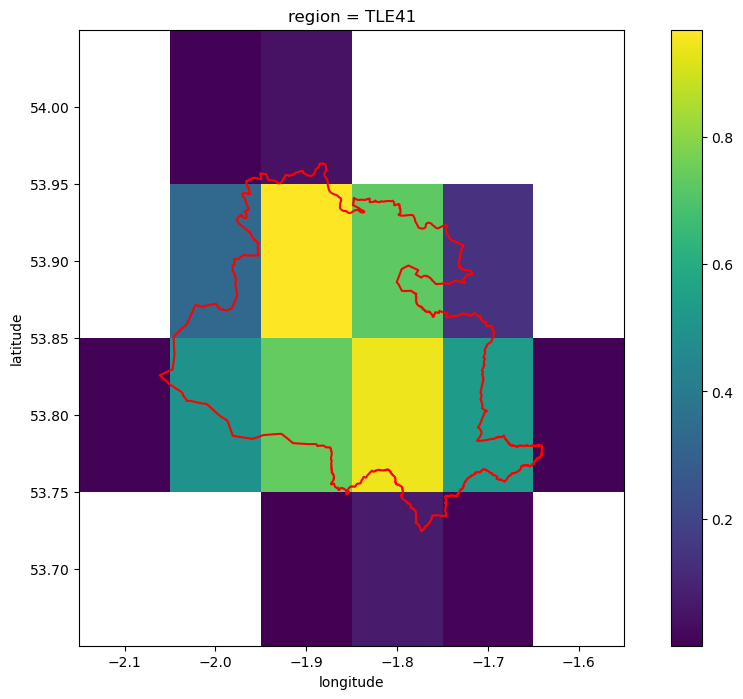

In [8]:
# Example plot

import matplotlib.pyplot as plt
region_to_plot = 'TLE41'

bradford = w.sel(region=region_to_plot).compute()

fig, ax = plt.subplots(figsize=(12, 8))
(bradford
     .rename({'lat':'latitude', 'lon':'longitude'})
     .where(bradford>0, drop = True).plot(ax = ax) )
georegions.plot_region(region_to_plot, ax=ax, color='red')

#### Run aggregation

In [9]:
def run_era5l_agg(year, input_path):
    # This function performs the actual aggregation for a single year, region.
    # Note that this function runs "lazily", i.e., returns an object that is
    # passed on to Dask for computation.
    
    clim = dataset.from_path(
        f"{input_path}tempPrecLand{year}.zarr", 
        var = 't2m', 
        engine = 'zarr', 
        preprocess=dataset.preprocess_era5l)

    clim.clip_data_to_georegions_extent(georegions)

    clim.rechunk(-1)

    # # Temporal aggregation to gridcell by day
    daily_list = [x.map_execute(clim) for x in daily]

    # # Sum across days after taking the non-linear transformation
    monthly_list = [monthly.map_execute(x) for x in daily_list]
    
    # # Spatial agregation
    out_clim = [spatial.map_execute(x, w) for x in monthly_list]
    
    # Return only the dask dataframes from the Datset objects
    return [x.da.data for x in out_clim]


In [ ]:
print('AGGREGATING YEARS')
output_list = list()
time_list = list()
for year in years:
    print(year)

    # Start timing
    start = time.time()
    time_list.append(year)

    # Aggregate this year, region & append to list
    output_list.append(dask.compute(run_era5l_agg(year, input_path))[0])

    # Report timing
    stop = time.time()
    duration = stop-start
    print(round(duration/60,2))

AGGREGATING YEARS
2019
[                                        ] | 2% Completed |  0.8s

/home/bearpark/.conda/envs/aggfly/lib/python3.8/site-packages/pygeos/predicates.py:906: RuntimeWarning: invalid value encountered in within
  return lib.within(a, b, **kwargs)


[####################################### ] | 98% Completed |  4min 48.3s

In [ ]:
print('COMBINING OUTPUT')
# Put everything together in one dataset

d_list = list()
for t in range(len(polys)):
    y_list = list()
    for y in range(len(years)):
        y_list.append(xr.DataArray(
            data = output_list[y][t],
            dims = ['region', 'year', 'month'],
            coords = dict(
                region=('region', georegions.regions),
                year = ('year', [years[y]]),
                month = ('month', np.arange(1,13))
            ),
            # name = f'temp',
            name = f'tavg{polys[t]}'
        ))
    d_list.append(xr.concat(y_list, dim='year'))

In [ ]:
# Save
ds = xr.combine_by_coords(d_list)    
ds = ds.to_dataframe()
ds = ds.reset_index(level=['region', 'year', 'month'])
ds = ds.rename(columns={'region':'id'})
ds

In [ ]:
plot_data = georegions.shp.merge(ds[ds.month == 6], on='id')
plot_data.plot(column = 'tavg1')

In [ ]:
ts=ds[ds.id == 'TLE41']
ts.tavg3.plot()

In [ ]:
ds.to_csv(os.path.join(output_path, output_name+'.csv'))